In [1]:
# ==============================
# Primera celda - Importaciones
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

sns.set(style='whitegrid')
print("Todas las librerías cargadas.")


Todas las librerías cargadas.


In [2]:
# ==============================
# Segunda celda - Carga de datos
# ==============================
datos = pd.read_csv("C:/RespaldoDB/comprar_alquilar.csv")
datos.head()


,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1


In [3]:
# ==============================
# Justificación del algoritmo
# ==============================
"""
Se elige PCA (Principal Component Analysis) porque:
- Permite reducir la dimensionalidad de los datos manteniendo la mayor parte de la varianza.
- Facilita la visualización y comprensión de relaciones entre variables.
- Puede mejorar la eficiencia de modelos posteriores y disminuir ruido.
- Es útil cuando los datos contienen variables correlacionadas (ej. gastos, ingresos, pagos).
"""


'\nSe elige PCA (Principal Component Analysis) porque:\n- Permite reducir la dimensionalidad de los datos manteniendo la mayor parte de la varianza.\n- Facilita la visualización y comprensión de relaciones entre variables.\n- Puede mejorar la eficiencia de modelos posteriores y disminuir ruido.\n- Es útil cuando los datos contienen variables correlacionadas (ej. gastos, ingresos, pagos).\n'

In [4]:
# ==============================
# Preprocesamiento
# ==============================
# Seleccionar columnas numéricas para PCA (excluyendo la variable objetivo 'comprar')
X = datos.drop(columns=['comprar'])

# Escalado de datos (importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
# ==============================
# Diseño del modelo PCA
# ==============================
"""
Diseño:
-------
- Algoritmo: PCA de scikit-learn.
- Número de componentes: 2 para visualización 2D.
- Entrenamiento con los datos escalados.
- Se visualizan los datos proyectados en el espacio reducido.
"""
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada por 2 componentes:", sum(pca.explained_variance_ratio_))


Varianza explicada por cada componente: [0.29913557 0.23294923]
Varianza total explicada por 2 componentes: 0.5320847979308863


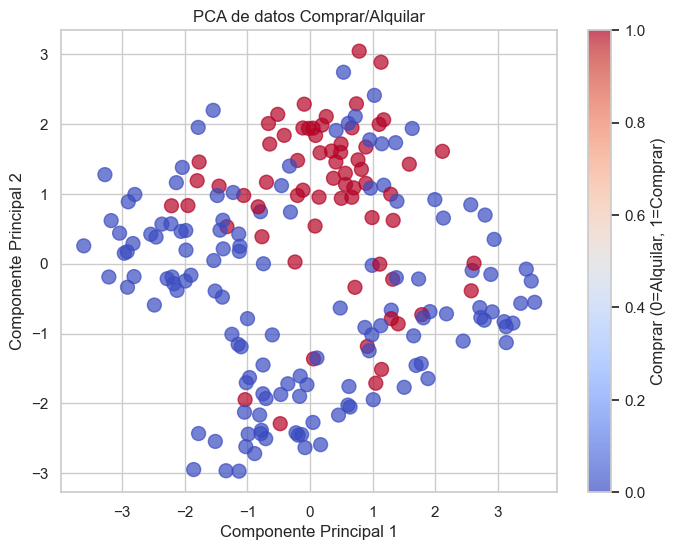

'\nInterpretación:\n---------------\n- Los datos se redujeron a dos dimensiones principales que capturan la mayor parte de la varianza.\n- Se observa cierta separación entre quienes compran y quienes alquilan.\n- Este análisis facilita la identificación de patrones y correlaciones ocultas entre variables financieras y sociales.\n'

In [6]:
# ==============================
# Gráfica personalizada
# ==============================
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=datos['comprar'], cmap='coolwarm', s=100, alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de datos Comprar/Alquilar')
plt.colorbar(label='Comprar (0=Alquilar, 1=Comprar)')
plt.show()

"""
Interpretación:
---------------
- Los datos se redujeron a dos dimensiones principales que capturan la mayor parte de la varianza.
- Se observa cierta separación entre quienes compran y quienes alquilan.
- Este análisis facilita la identificación de patrones y correlaciones ocultas entre variables financieras y sociales.
"""


In [7]:
# ==============================
# Guardar modelo y escalador
# ==============================
joblib.dump(pca, "modelo_pca_comprar_alquilar.pkl")
joblib.dump(scaler, "scaler_comprar_alquilar.pkl")
print("Modelo PCA y escalador guardados.")


Modelo PCA y escalador guardados.
